# Hunting Interferring Predator Prey Model
Extension fo the Interferring Predator Prey model with predators hunting prey. Hunting is added by creating a RotationEvent and turning predators towards the closest prey they see (sight limited). Prey are stationary and stored in an Rtree for fast neighbour searches within prey sight.

In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from multiprocessing import Pool
from tqdm import tqdm
import warnings

# import datatime to set threads to 1
# allows for better multiprocessing
import datatable as dt
dt.options.nthreads = 1

# set nice plotting style
plt.style.use('bmh')

# IEBM modules
# point path to IEBM files
import sys
sys.path.append('../../')
# model population in 2-dimensions
from iebm.populations.population2D import Population2D
# import Trait classes to set up Events
from iebm.traits.static_trait import StaticTrait
from iebm.traits.linked_trait import LinkedTrait
# import BirthEvent for the prey
from iebm.events.birth import BirthEvent
# import DeathEvent for the predator
from iebm.events.death import DeathEvent
# movement is simulated by time to boundary (wall) events
from iebm.events.wall import WallEvent
# import 2D interaction for 2D populations
from iebm.events.interact2d import Interact2DEvent
# import class to simulate model
from iebm.simulation import Simulation
# event that pauses an individual for an alloted time
from iebm.events.pause import Pause2DEvent
# load rotate module for predators to hunt
from iebm.events.rotate import RotateEvent

## Parameters
Set parameters that are used in both the ODE and IEBM. Values selected to have small populations for faster simulations.

In [2]:
r = 0.001 # prey growth rate
a = 1 # predator attack rate
c = 1 # predator conversion efficiency
d = 0.001 # predator death rate
# size of environment
xdim = 500
ydim = 500
A = xdim * ydim
init_prey = 100 # starting prey population size
init_pred = 100 # starting predator population size
h = 75
# set the simulation time to certain number of cycles

time = 100000
ode_step = 200
ode_times = np.linspace(0, time, ode_step)

# for the IEBM, individuals need explicit size
prey_radius = 1
pred_radius = 1

In [3]:
# function to setup an interferring Rosenzweig-MacArthur model with a different carrying capacities
# predators have two new traits:
# 1. hunt_radius is the distance a predator can look for nearby prey
#    the hunt_radius is the radius of the individual multiplied by 
#    the hunt_radius_factor
# 2. hunt_rate is the rate at which a predator looks nearby prey.
#    the hunt_rate is the death rate multiplied by a hunt_rate_factors.
#    the thought is to control hunt updates as a factor of life time.
# the two new predator traits are associated with a RotationEvent.
# the RotationEvent turns predators towards nearby prey, which are set
# as attracting_population.
def hirm_setup(k, stoppage, hunt_radius_factor, hunt_rate_factor):

    prey = Population2D(name='prey', init_size=init_prey, xdim=xdim, ydim=ydim, implicit_capacity=k)
    pred = Population2D(name='pred', init_size=init_pred, xdim=xdim, ydim=ydim)

    vel = a / (2 * (prey_radius + pred_radius))

    trait_prey = [(StaticTrait, {'name' : 'birth_rate', 
                                 'value' : r}), 
                  (StaticTrait, {'name' : 'radius', 
                                 'value' : prey_radius}),
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x : x})]

    event_prey = [(BirthEvent, {'name' : 'birth' , 
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : False, 
                                'current_time' : 0})]

    trait_pred = [(StaticTrait, {'name' : 'radius', 
                                 'value' : pred_radius}), 
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x}),
                  (LinkedTrait, {'name' : 'interfer_radius',
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x}),
                  (StaticTrait, {'name' : 'velocity', 
                                 'value' : vel}),
                  (StaticTrait, {'name' : 'death_rate', 
                                 'value' : d}), 
                  (StaticTrait, {'name' : 'handling', 
                                 'value' : h}),                   
                  (StaticTrait, {'name' : 'stoppage', 
                                 'value' : stoppage}), 
                  (LinkedTrait, {'name' : 'hunt_radius',
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x * hunt_radius_factor}), 
                  (StaticTrait, {'name' : 'hunt_rate', 
                                 'link_trait' : 'death_rate',
                                 'link_func' : lambda x : x * hunt_rate_factor})]
    
    event_pred = [(DeathEvent, {'name' : 'death',
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (WallEvent, {'name' : 'wall', 
                               'is_primary' : True, 
                               'current_time' : 0, 
                               'bounce' : 'random'}), 
                  (Interact2DEvent, {'name' : 'predation',
                                     'is_primary' : True,
                                     'tirgger_set_next' : True,
                                     'current_time'  : 0, 
                                     'other' : prey}), 
                  (Pause2DEvent, {'name' : 'handling',
                                  'ignore_list' : ['death'],
                                  'is_primary' : False}),
                  (Interact2DEvent, {'name' : 'interfer',
                                     'is_primary' : True,
                                     'tirgger_set_next' : True,
                                     'current_time'  : 0}), 
                  (Pause2DEvent, {'name' : 'stoppage',
                                  'ignore_list' : ['death'],
                                  'is_primary' : False}),
                  (BirthEvent, {'name' : 'birth', 
                                'is_primary' : False, 
                                'current_time' : 0}), 
                  (RotateEvent, {'name' : 'hunt', 
                                 'is_primary' : True,
                                 'attract_population' : prey,
                                 'current_time' : 0})]   
    
    return prey, pred, trait_prey, trait_pred, event_prey, event_pred

In [4]:
# function to run am intereferring Rosenzweig-MacArthur model from the returned value of rm_setup.
def hirm_model(prey, pred, trait_prey, trait_pred, event_prey, event_pred, progress_bar=True):
    
    prey.add_traits(trait_prey)
    prey.add_events(event_prey)
    pred.add_traits(trait_pred)
    pred.add_events(event_pred)    
    
    # list what events to stop at pause
    # predation
    set_list = [c for c in pred.event_list if c not in pred.event_dict['handling'].ignore_list]
    pred.event_dict['handling'].set_list = set_list
    # interference
    set_list = [c for c in pred.event_list if c not in pred.event_dict['stoppage'].ignore_list]
    pred.event_dict['stoppage'].set_list = set_list

    # add event triggers to finish setting up system
    # when new prey is born, check and create new predation collisions
    # and add new offspring to hunt rtree
    def prey_birth(params):
        new_events = []
        new_events += pred.event_dict['predation'].set_other_next(params)
        new_events += pred.event_dict['hunt'].add_attracted(params)
        return new_events
    prey.event_dict['birth'].triggers = prey_birth

    # when prey dies, remove from hunt indes
    prey.event_dict['death'].triggers = pred.event_dict['hunt'].remove_attracted

    # set the trigger for a predation interaction event
    # a few things occur at a predation event, so we need a function
    def predation_trigger(params):
        events = []
        other_params = params.copy()
        other_params['actor_id'] = other_params['extra']
        # the prey is removed
        events += prey.event_dict['death'].handle(other_params)
        # the predator pauses to handle 
        events += pred.event_dict['handling'].set_next(params)
        return events
    pred.event_dict['predation'].triggers = predation_trigger

    # after handling, predator can give birth and get new settings
    def handle_trigger(params):
        events = []
        # now that individual is active:
        # set new wall times
        pred.event_dict['wall'].set_next(params)
        # set next predation times
        pred.event_dict['predation'].set_next(params)
        # set next interfer times
        pred.event_dict['interfer'].set_next(params)
        # possibly create offspring after handling
        events += pred.event_dict['birth'].handle(params)
        # get individual's next evet
        events += [pred.get_next_event(params['actor_id'])]
        return events
    pred.event_dict['handling'].triggers = handle_trigger

    # set triggers when individual predators collide
    def stoppage_trigger(params):
        events = []
        # stop other
        other_params = params.copy()
        other_params['actor_id'] = other_params['extra']
        events += pred.event_dict['stoppage'].set_next(other_params)
        # stop this individual
        events += pred.event_dict['stoppage'].set_next(params)
        return events
    pred.event_dict['interfer'].triggers = stoppage_trigger

    # after stopping, predators can resume activity
    def resume_trigger(params):
        events = []
        # set new wall times
        pred.event_dict['wall'].set_next(params)
        # set next predation times
        pred.event_dict['predation'].set_next(params)
        # set next interfer times
        pred.event_dict['interfer'].set_next(params)
        # get individuals next event
        events += [pred.get_next_event(params['actor_id'])]
        return events
    pred.event_dict['stoppage'].triggers = resume_trigger

    # set triggers to calculate new interactions after wall collision
    def new_interactions(params):
        new_events = []
        new_events += pred.event_dict['predation'].set_next(params)
        new_events += pred.event_dict['interfer'].set_next(params)
        return new_events
    pred.event_dict['wall'].triggers = new_interactions

    # hunt trigger, change direction after angle change
    # exact same as resume
    pred.event_dict['hunt'].triggers = resume_trigger
    
    # add the pops to a dictionary 
    pop_dict = {str(prey) : prey, 
                str(pred) : pred}

    # create the simulation with the population dictionary
    sim = Simulation(pop_dict)
    
    # run simulation
    sim.run(time, progress_bar=progress_bar)

    # return simulation resuls
    res = sim.get_results()
    
    return res

In [5]:
# function to run in parallel
def run_parallel(k, s, hrad, hrat):
    
    prey, pred, trait_prey, trait_pred, event_prey, event_pred = hirm_setup(k, s, hrad, hrat)
    res = hirm_model(prey, pred, trait_prey, trait_pred, event_prey, event_pred, progress_bar=False)  
    return [k, s, hrad, hrat, res]

In [ ]:
%%time
# run IEBM a few times on select carrying capacties, stoppage, and hunt_factors

ks = [2000, 4000]
ss = [5, 75]
hrads = [2, 10]
hrats = [100, 1000]
runs = 1 #99
params = [(k, s, hrad, hraf) for k in ks for s in ss for hrad in hrads for hrats in hrats for _ in range(runs)]

pbar = tqdm(total=len(params))

res = []
def update(a):
    res.append(a)
    pbar.update()

pool = Pool()

for (k, s, hrad, hrat) in params:
    pool.apply_async(run_parallel, (k, s, hrad, hrat), 
                     callback=update)

pool.close()
pool.join()
pbar.close()

res = pd.DataFrame(res, columns = ['k', 's', 'hrad', 'hrat', 'out'])

In [12]:
# format parallel results

res_df = []
for k, g1 in res.groupby('k'):
    for (s,hf), g2 in g1.groupby(['s', 'hf']):
        all_temp = []
        for go in g2.out:
            temp_df = pd.DataFrame()
            temp_df['time'] = go['time']
            for p in go['size']:
                temp_df[p] = go['size'][p] 
            all_temp.append(temp_df)
        all_temp = pd.concat(all_temp, ignore_index=True)
        all_temp['k'] = k
        all_temp['s'] = s
        all_temp['hf'] = hf
        res_df.append(all_temp)

# combine runs by averaging at integer time stamps
res_df = pd.concat(res_df, ignore_index=True)
res_df['time_int'] = res_df['time'].astype(np.int64)
res_grp = res_df.groupby(['k', 's', 'hf', 'time_int']).agg({'prey' : np.mean, 'pred' : np.mean}).reset_index()

In [16]:
# function to get integration results of an ODE with a set carrying capacity
def run_ode(k):
    
    ode_times = np.linspace(0, time, ode_step) # inference times

    # create exponential growth equation as a function of N
    def dN_dt(N, t=0):
        return np.array([r*N[0]*(1-N[0]/k) - (a/A)*N[0]*N[1]/(1+(a/A)*h*N[0]),
                         c*(a/A)*N[0]*N[1]/(1+(a/A)*h*N[0]) - d*N[1]])

    # integrate growth equation
    X, info = integrate.odeint(dN_dt, [init_prey, init_pred], ode_times, full_output=1)
    # format and store results
    ode_prey = X[:, 0]
    ode_pred = X[:, 1]     
    
    return ode_prey, ode_pred

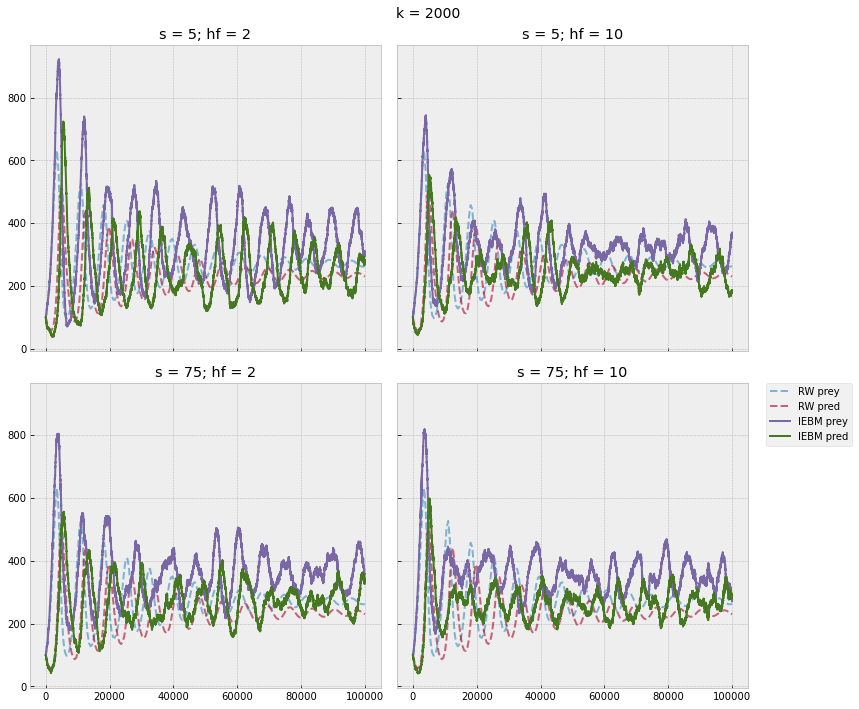

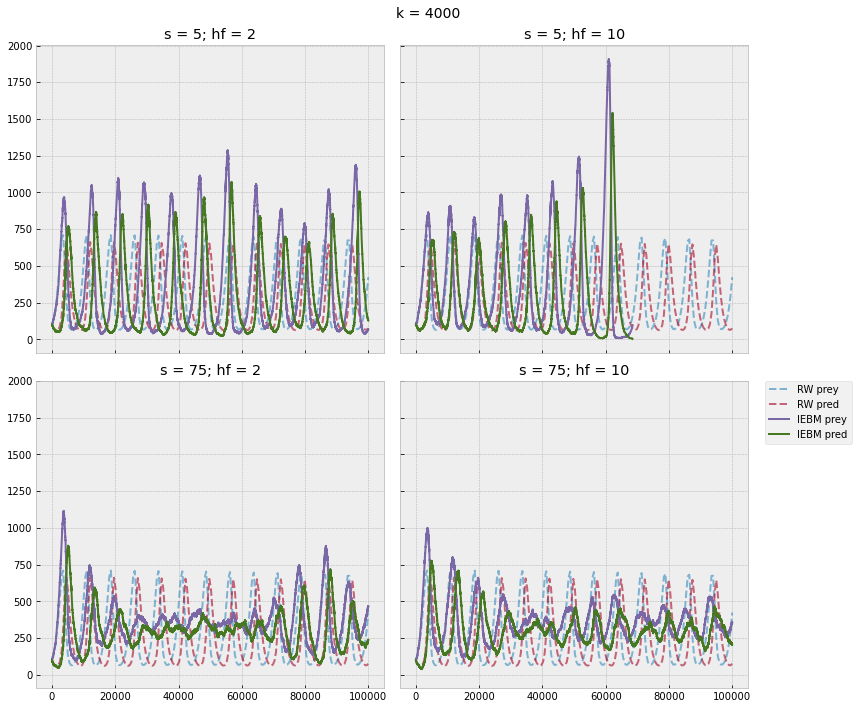

In [28]:
for k, g1 in res_grp.groupby('k'):
    
    ode_prey, ode_pred = run_ode(k)
    fig, ax = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
    
    for t, ((s, hf), g2) in enumerate(g1.groupby(['s', 'hf'])):
        
        if t == 0:
            t = (0,0)
        elif t == 1:
            t = (0,1)
        elif t == 2:
            t = (1,0)
        else:
            t = (1,1) 
        
        ax[t].plot(ode_times, ode_prey, ls='--', alpha=0.6, label='RW prey')
        ax[t].plot(ode_times, ode_pred, ls='--', alpha=0.6, label='RW pred')
    
        ax[t].plot(g2.time_int, g2.prey, label='IEBM prey')
        ax[t].plot(g2.time_int, g2.pred, label='IEBM pred')
        ax[t].set_title(f's = {s}; hf = {hf}')
    
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    plt.suptitle(f'k = {k}', fontsize=14)
    plt.tight_layout()
    plt.show()

     